In [1]:
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from scipy import stats
import scipy
import csv
import pandas as pd
import math
import statsmodels
import networkx as nx
import itertools
import seaborn as sns
import random
import os
from textwrap import wrap
import pickle
from sklearn.model_selection import train_test_split, cross_validate
from sklearn import metrics
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [2]:
def load_spots(chromosome):
    with open("data/spots/"+chromosome+"_hotspot_data.pickle", "rb") as fp:
         hotspot_data = pickle.load(fp)
    with open("data/spots/"+chromosome+"_coldspot_data.pickle", "rb") as fp:
         coldspot_data = pickle.load(fp)
    return hotspot_data, coldspot_data

def create_dataset(hotspots, coldspots, only_seq=False):
    X, y = [], []
    for row in hotspots:
        if only_seq: row = row[:, :4]
        X.append(row.flatten())
        y.append(1)
    
    for row in coldspots:
        if only_seq: row = row[:, :4]
        X.append(row.flatten())
        y.append(0)
    
    return np.array(X), np.array(y)

Logistic Regression

https://towardsdatascience.com/logistic-regression-using-python-sklearn-numpy-mnist-handwriting-recognition-matplotlib-a6b31e2b166a

In [3]:
def get_data(chromosomes):
    hotspots, coldspots = [], []
    for chromosome in chromosomes:
        hotspot, coldspot = load_spots(chromosome)
        hotspots+=hotspot
        coldspots+=coldspot
    return hotspots, coldspots

In [4]:
train_chromosomes = ['chr{}'.format(i) for i in range(1, 10, 2)]
train_hotspot, train_coldspot = get_data(train_chromosomes)

test_chromosomes = ['chr{}'.format(i) for i in range(11, 12)]
test_hotspot, test_coldspot = get_data(test_chromosomes)

In [5]:
models = ['Logistic Regression', 'Support Vector Machine', 'K-Nearest Neighbors', 'Decision Tree Classifier', 
          'Naïve Bayes', 'Simple NN', 'CNN-RNN Hybrid']

cv_seq = [0.5941378429691556, 0.668783587878285, 0.563639058842192, 0.513834890616283, 
         0.6860422176846643,  0.61, 0.6688]
test_score_seq = [0.5826645264847512, 0.6613162118780096, 0.5585874799357945, 0.5184590690208668, 
                  0.5762439807383628, 0.6902086677367576]

cv_exo = [0.7053266116242571, 0.7442793063116689, 0.6222286079030622, 0.6170101064491916, 
          0.7153845463749168, 0.715, 0.77]
test_score_exo = [0.7158908507223114, 0.7688603531300161, 0.6051364365971108, 0.6179775280898876, 
                  0.7030497592295345, 0.7335473515248796]

cv_exo, cv_seq, models =  zip(*sorted(zip(cv_exo, cv_seq, models)))


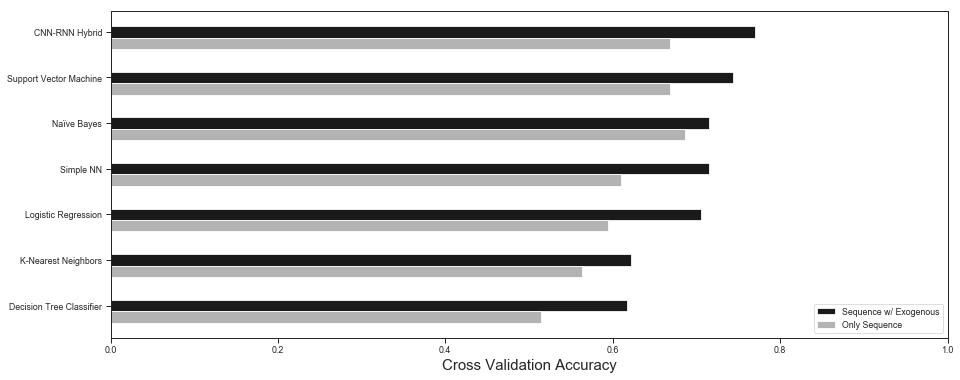

In [6]:
sns.set_style("ticks")
sns.set_context("paper", rc={"font.size":15,"axes.titlesize":15,"axes.labelsize":15}) 

# set width of bar
barWidth = 0.25
 
# set height of bar
bars1 = cv_seq
bars2 = cv_exo
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
# Make the plot
plt.figure(figsize=(15,6))
plt.barh(r2, bars2, color='.1', height=barWidth, edgecolor='white', label='Sequence w/ Exogenous')
plt.barh(r1, bars1, color='.7', height=barWidth, edgecolor='white', label='Only Sequence')
 
# Add xticks on the middle of the group bars
plt.yticks([r + barWidth for r in range(len(bars1))], models)
plt.xlabel('Cross Validation Accuracy')
plt.xlim(0,1) 
# Create legend & Show graphic
plt.legend(loc='lower right')
plt.savefig("img/CV.png", bbox_inches='tight')

In [14]:
def try_classifier(model, X, y, only_seq):
    X, y = create_dataset(hotspot, coldspot, only_seq=only_seq)
    x_train, x_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, test_size=0.2, random_state = 0)

    results = cross_validate(model, x_train, y_train, cv=5,return_estimator=True)
    cv_scores = np.mean(results['test_score'])
    print('cv: {}'.format(cv_scores))

    model.fit(x_train, y_train)
    test_score = model.score(x_test, y_test)
    print('test_score: {}'.format(test_score))
    prob = model.predict_proba(x_test)
    return prob

Logistic Regression

In [15]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(random_state=0, max_iter=100, solver='lbfgs', multi_class='multinomial')
LR_seq = try_classifier(model, X, y, only_seq=True)
LR_exo = try_classifier(model, X, y, only_seq=False)

cv: 0.631419739331523
test_score: 0.6747340835517188
cv: 0.659472998633374
test_score: 0.6653306613226453


SVM

In [ ]:
from sklearn.svm import SVC
model = SVC(gamma='auto', probability=True)
SVM_seq = try_classifier(model, X, y, only_seq=True)
SVM_exo = try_classifier(model, X, y, only_seq=False)

K-Nearest Neighbours

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors = 2)
KNN_seq = try_classifier(model, X, y, only_seq=True)
KNN_exo = try_classifier(model, X, y, only_seq=False)

Decision Tree Classifier

In [32]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(max_depth=10, random_state=0)
DT_seq = try_classifier(model, X, y, only_seq=True)
DT_exo = try_classifier(model, X, y, only_seq=False)

cv: 0.513834890616283
test_score: 0.5184590690208668
cv: 0.6170101064491916
test_score: 0.6179775280898876


Stochastic Gradient Descent

In [33]:
from sklearn.linear_model import SGDClassifier
model = SGDClassifier(loss='modified_huber', random_state=0)
SGD_seq = try_classifier(model, X, y, only_seq=True)
SGD_exo = try_classifier(model, X, y, only_seq=False)

cv: 0.5921201270609063
test_score: 0.5858747993579454
cv: 0.6888687704856271
test_score: 0.6998394863563403


Naïve Bayes

In [34]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
NB_seq = try_classifier(model, X, y, only_seq=True)
NB_exo = try_classifier(model, X, y, only_seq=False)

cv: 0.6860422176846643
test_score: 0.6902086677367576
cv: 0.7153845463749168
test_score: 0.7335473515248796


In [47]:
with open("data/8paramSimple.txt", "rb") as fp:
    SNN_prob = pickle.load(fp)

In [48]:
with open("models_prob.txt", "wb") as fp:
    SNN_prob = np.array([1-np.array(SNN_prob[:,0]), SNN_prob[:,0]]).T
    pickle.dump([ns_probs, LR_exo, SVM_exo, KNN_exo, DT_exo, SGD_exo, NB_exo, SNN_prob, CR_exo], fp)

No Skill: ROC AUC=0.500
Logistic Regression: ROC AUC=0.768
Support Vector Machine: ROC AUC=0.843
K-Nearest Neighbors: ROC AUC=0.652
Decision Tree Classifier: ROC AUC=0.627
Naïve Bayes: ROC AUC=0.755
Simple NN: ROC AUC=0.822
CNN-RNN Hybrid: ROC AUC=0.869


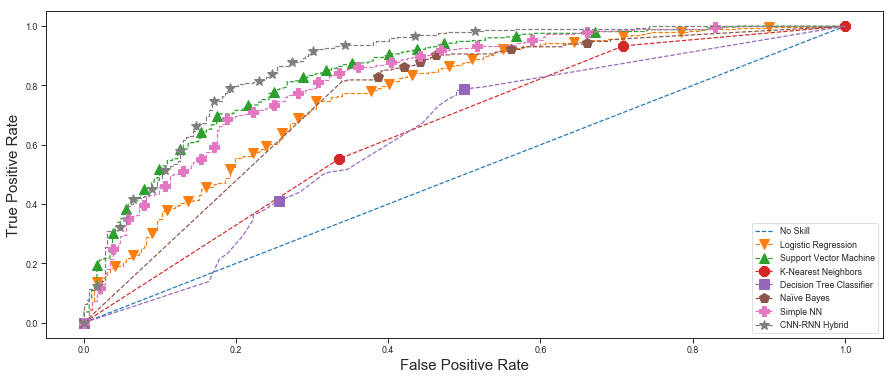

In [13]:
X, y = create_dataset(hotspot, coldspot, only_seq=False)
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, test_size=0.2, random_state = 0)

with open("models_prob.txt", "rb") as fp:
    models_prob = pickle.load(fp)

ns_probs, LR_exo, SVM_exo, KNN_exo, DT_exo, SGD_exo, NB_exo, SNN_prob, CR_exo = models_prob
models_prob = [ns_probs, LR_exo, SVM_exo, KNN_exo, DT_exo, NB_exo, SNN_prob, CR_exo]
    
# ns_probs, LR_exo, SVM_exo, KNN_exo, DT_exo, SGD_exo, NB_exo, SNN_exo, CR_exo
models =  ['No Skill', 'Logistic Regression', 'Support Vector Machine', 'K-Nearest Neighbors', 'Decision Tree Classifier', 
           'Naïve Bayes', 'Simple NN', 'CNN-RNN Hybrid']
# calculate scores

auc_score = [roc_auc_score(y_test , model[:,1]) for model in models_prob]

# summarize scores
for i in range(8):
    print('{}: ROC AUC=%.3f'.format(models[i]) % (auc_score[i]))

# calculate roc curves
fprs = [roc_curve(y_test , model[:,1])[0] for model in models_prob]
tprs = [roc_curve(y_test , model[:,1])[1] for model in models_prob]
markers = ['',"v", "^", "8", "s", "p", "P", "*", '.']

plt.figure(figsize=(15,6))
# plot the roc curve for the model
for i in range(8):
    if models[i] == 'K-Nearest Neighbors':
        plt.plot(fprs[i], tprs[i], marker=markers[i], label=models[i], markersize=10, linestyle='dashed', markevery=1)
    else:
        plt.plot(fprs[i], tprs[i], marker=markers[i], label=models[i], markersize=10, linestyle='dashed', markevery=10)

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.savefig("img/ROC.png", bbox_inches='tight')

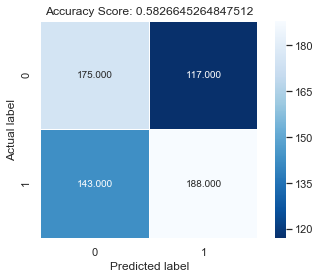

In [5]:
X, y = create_dataset(hotspot, coldspot, only_seq=True)

clf = LogisticRegression(random_state=0, max_iter=300, solver='lbfgs', multi_class='multinomial').fit(x_train, y_train)
prediction = clf.predict(x_test)
prediction_prob = clf.predict_proba(x_test) 
score = clf.score(x_test, y_test)


result = metrics.confusion_matrix(y_test, prediction)
sns.heatmap(result, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title)
plt.show()

In [9]:
X, y = create_dataset(hotspot, coldspot, only_seq=False)

x_train, x_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, test_size=0.2, random_state = 0)
clf = LogisticRegression(random_state=0, max_iter=500, solver='lbfgs', multi_class='multinomial').fit(x_train, y_train)
prediction = clf.predict(x_test)
prediction_prob = clf.predict_proba(x_test) 
score = clf.score(x_test, y_test)

result = metrics.confusion_matrix(y_test, prediction)
sns.heatmap(result, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title)
plt.show()

NameError: name 'LogisticRegression' is not defined

PCA and T-SNE

https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60

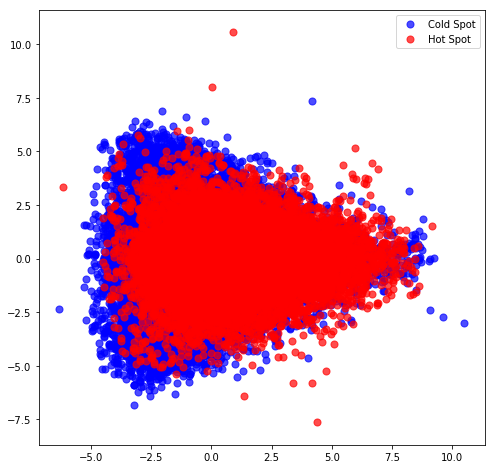

In [9]:
X, y = create_dataset(train_hotspot, train_coldspot, only_seq=True)

from sklearn.decomposition import PCA
from sklearn.decomposition import SparsePCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf, pd.DataFrame(y, columns=['target'])], axis = 1)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
targets = [0, 1]
# colors = ['.7', '.1']
colors = ['b', 'r']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['target'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50, alpha=0.7)
ax.legend(['Cold Spot', 'Hot Spot'])
plt.savefig("img/NoExoPCA_train.png", bbox_inches='tight')

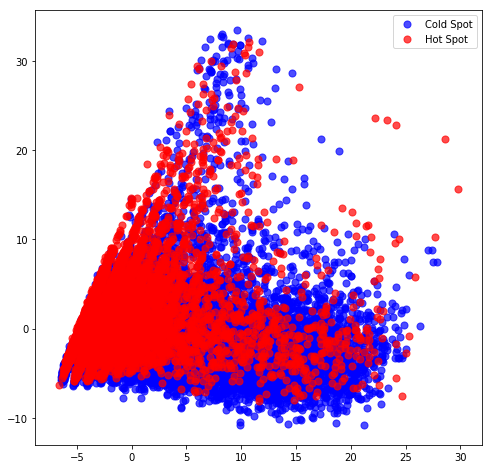

In [10]:
X, y = create_dataset(train_hotspot, train_coldspot, only_seq=False)

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf, pd.DataFrame(y, columns=['target'])], axis = 1)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
targets = [0, 1]
# colors = ['.7', '.1']
colors = ['b', 'r']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['target'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50, alpha=0.5)
ax.legend(['Cold Spot', 'Hot Spot'])
plt.savefig("img/ExoPCA_train.png", bbox_inches='tight')

In [ ]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 8878 samples in 4.638s...


(-20, 20)

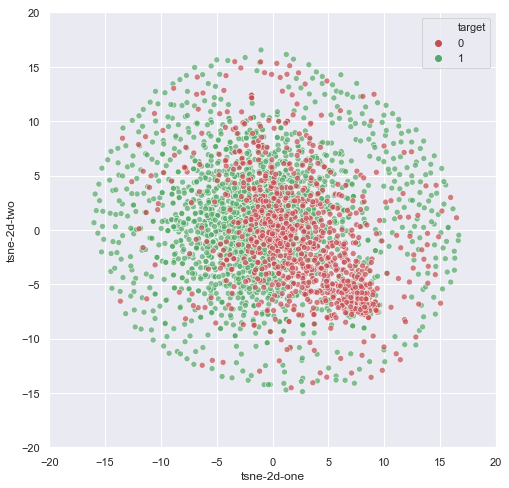

In [22]:
finalDf['tsne-2d-one'] = tsne_results[:,0]
finalDf['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(8,8))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue='target',
    palette=['r', 'g'],
    data=finalDf,
    legend="full",
    alpha=0.7
)
size = 20
plt.ylim([-size,size])
plt.xlim([-size,size])

Random Forest

https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

https://analyticsindiamag.com/7-types-classification-algorithms/

In [66]:
chromosome='chr17'
with open("data/spots/"+chromosome+"_midspot_data.txt", "rb") as fp:
    midspot_data = pickle.load(fp)